In [1]:
using NCDatasets
using CairoMakie
using Printf

In [2]:
include("../src/shear_instability.jl");

In [3]:
Ri = 0.1
simulation = initialize_shear_layer(Ri)
model = simulation.model
grid = simulation.model.grid

[ Info: Setting initial conditions
┌ Warning: Overwriting existing ./../data/raw_output/shear_instability_state_Ri=0.1.nc.
└ @ Oceananigans.OutputWriters ~/.julia/packages/Oceananigans/ctYdG/src/OutputWriters/netcdf_output_writer.jl:359
┌ Warning: Overwriting existing ./../data/processed_output/shear_instability_TKE_Ri=0.1.nc.
└ @ Oceananigans.OutputWriters ~/.julia/packages/Oceananigans/ctYdG/src/OutputWriters/netcdf_output_writer.jl:359


64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── Periodic x ∈ [-5.0, 5.0)      regularly spaced with Δx=0.15625
├── Flat y
└── Bounded  z ∈ [-5.0, 5.0]      regularly spaced with Δz=0.15625

In [4]:
shear_flow = model.background_fields.velocities.u.func
stratification = model.background_fields.tracers.b.func

h = model.background_fields.tracers.b.parameters.h;

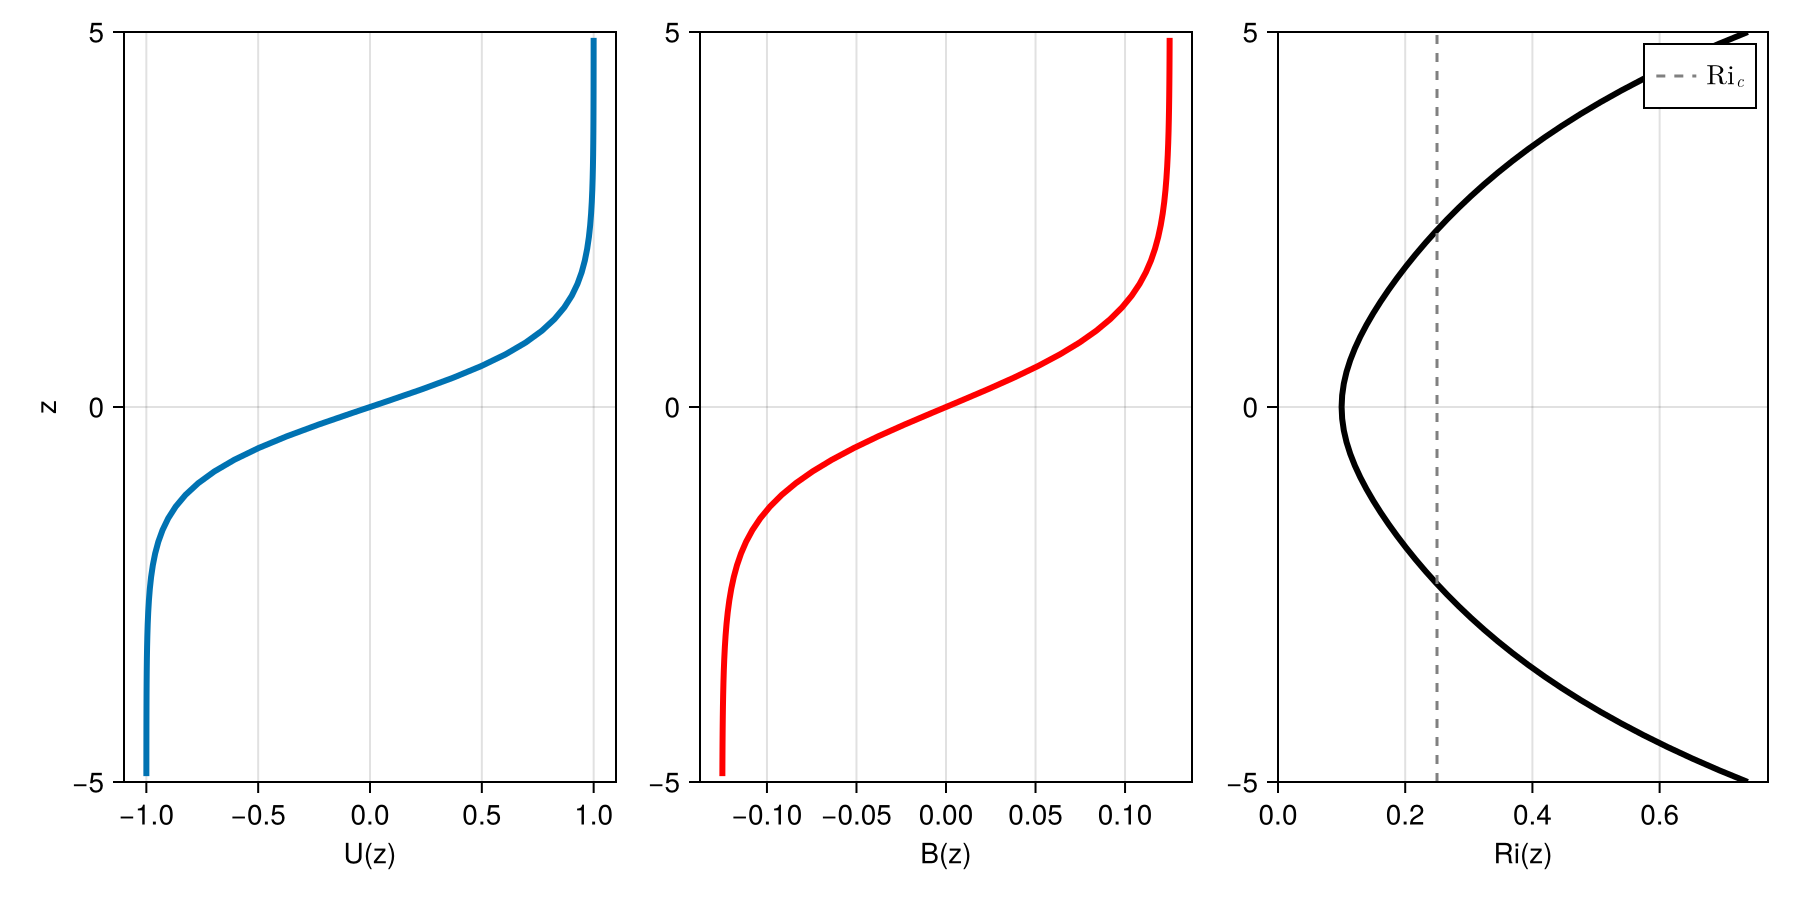

In [5]:
zF = znodes(grid, Face())
zC = znodes(grid, Center())

fig = Figure(size = (900, 450))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-5, 5)))
lines!(ax, shear_flow.(0, zC, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [stratification(0, z, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((0, nothing), (-5, 5)))
lines!(
    ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zF], zF;
    linewidth = 3, color = :black,
) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand
vlines!(ax, [0.25], linestyle=:dash, color=:gray, label=L"Ri$_{c}$") # Critical Richardson number
axislegend(ax)

fig

In [6]:
@info "*** Running a simulation of Kelvin-Helmholtz (stratified shear) instability..."
run!(simulation)

[ Info: *** Running a simulation of Kelvin-Helmholtz (stratified shear) instability...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (3.964 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.317 seconds).
[ Info: Simulation is stopping after running for 47.041 seconds.
[ Info: Model iteration 2500 equals or exceeds stop iteration 2500.


In [7]:
ds = NCDataset(simulation.output_writers[:state].filepath, "r")
show(ds)
close(ds)

Dataset: ./../data/raw_output/shear_instability_state_Ri=0.1.nc
Group: /

Dimensions
   zC = 64
   zF = 65
   xC = 64
   yF = 1
   xF = 64
   yC = 1
   time = 145

Variables
  zC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  zC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the z-direction.

  zF   (65)
    Datatype:    Float64 (Float64)
    Dimensions:  zF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the z-direction.

  xC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  xC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the x-direction.

  yF   (1)
    Datatype:    Float64 (Float64)
    Dimensions:  yF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the y-direction.

  xF   (64)
    Datatype:    Float64 (Float64)
    Dimensions: 

closed Dataset

In [8]:
@info "Making a neat movie of stratified shear flow..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

times = ds["time"][:]
t_final = times[end]

n = Observable(1)

xb = ds["xC"]
zb = ds["zC"]
Bₙ = @lift ds["B"][:, 1, :, $n]

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("buoyancy [m/s²] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, ds["B"][:, 1, :, :]), maximum(abs, ds["B"][:, 1, :, :]))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../animations/shear_instability_movie.mp4", frames, framerate=8) do i
    n[] = i
end

close(ds)

[ Info: Making a neat movie of stratified shear flow...


closed Dataset

In [9]:
@info "Making a neat movie of tracer mixing by stratified shear flow..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

times = ds["time"][:]
t_final = times[end]

n = Observable(1)

xc = ds["xC"]
zc = ds["zC"]
cₙ = @lift ds["c"][:, 1, :, $n]

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xc[1], xc[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("tracer concentration [mol/m³] at t = %.2f", times[$n])

ax_c = Axis(fig[1, 1]; title = title, kwargs...)

c_lims = (0, 1)

hm_c = heatmap!(ax_c, xc, zc, cₙ; colorrange = c_lims, colormap = :Greens)
Colorbar(fig[1, 2], hm_c)

frames = 1:length(times)

record(fig, "../animations/shear_instability_tracer_movie.mp4", frames, framerate=8) do i
    n[] = i
end

close(ds)

[ Info: Making a neat movie of tracer mixing by stratified shear flow...


closed Dataset

[ Info: Plotting some snapshots of the simulation at difference times...


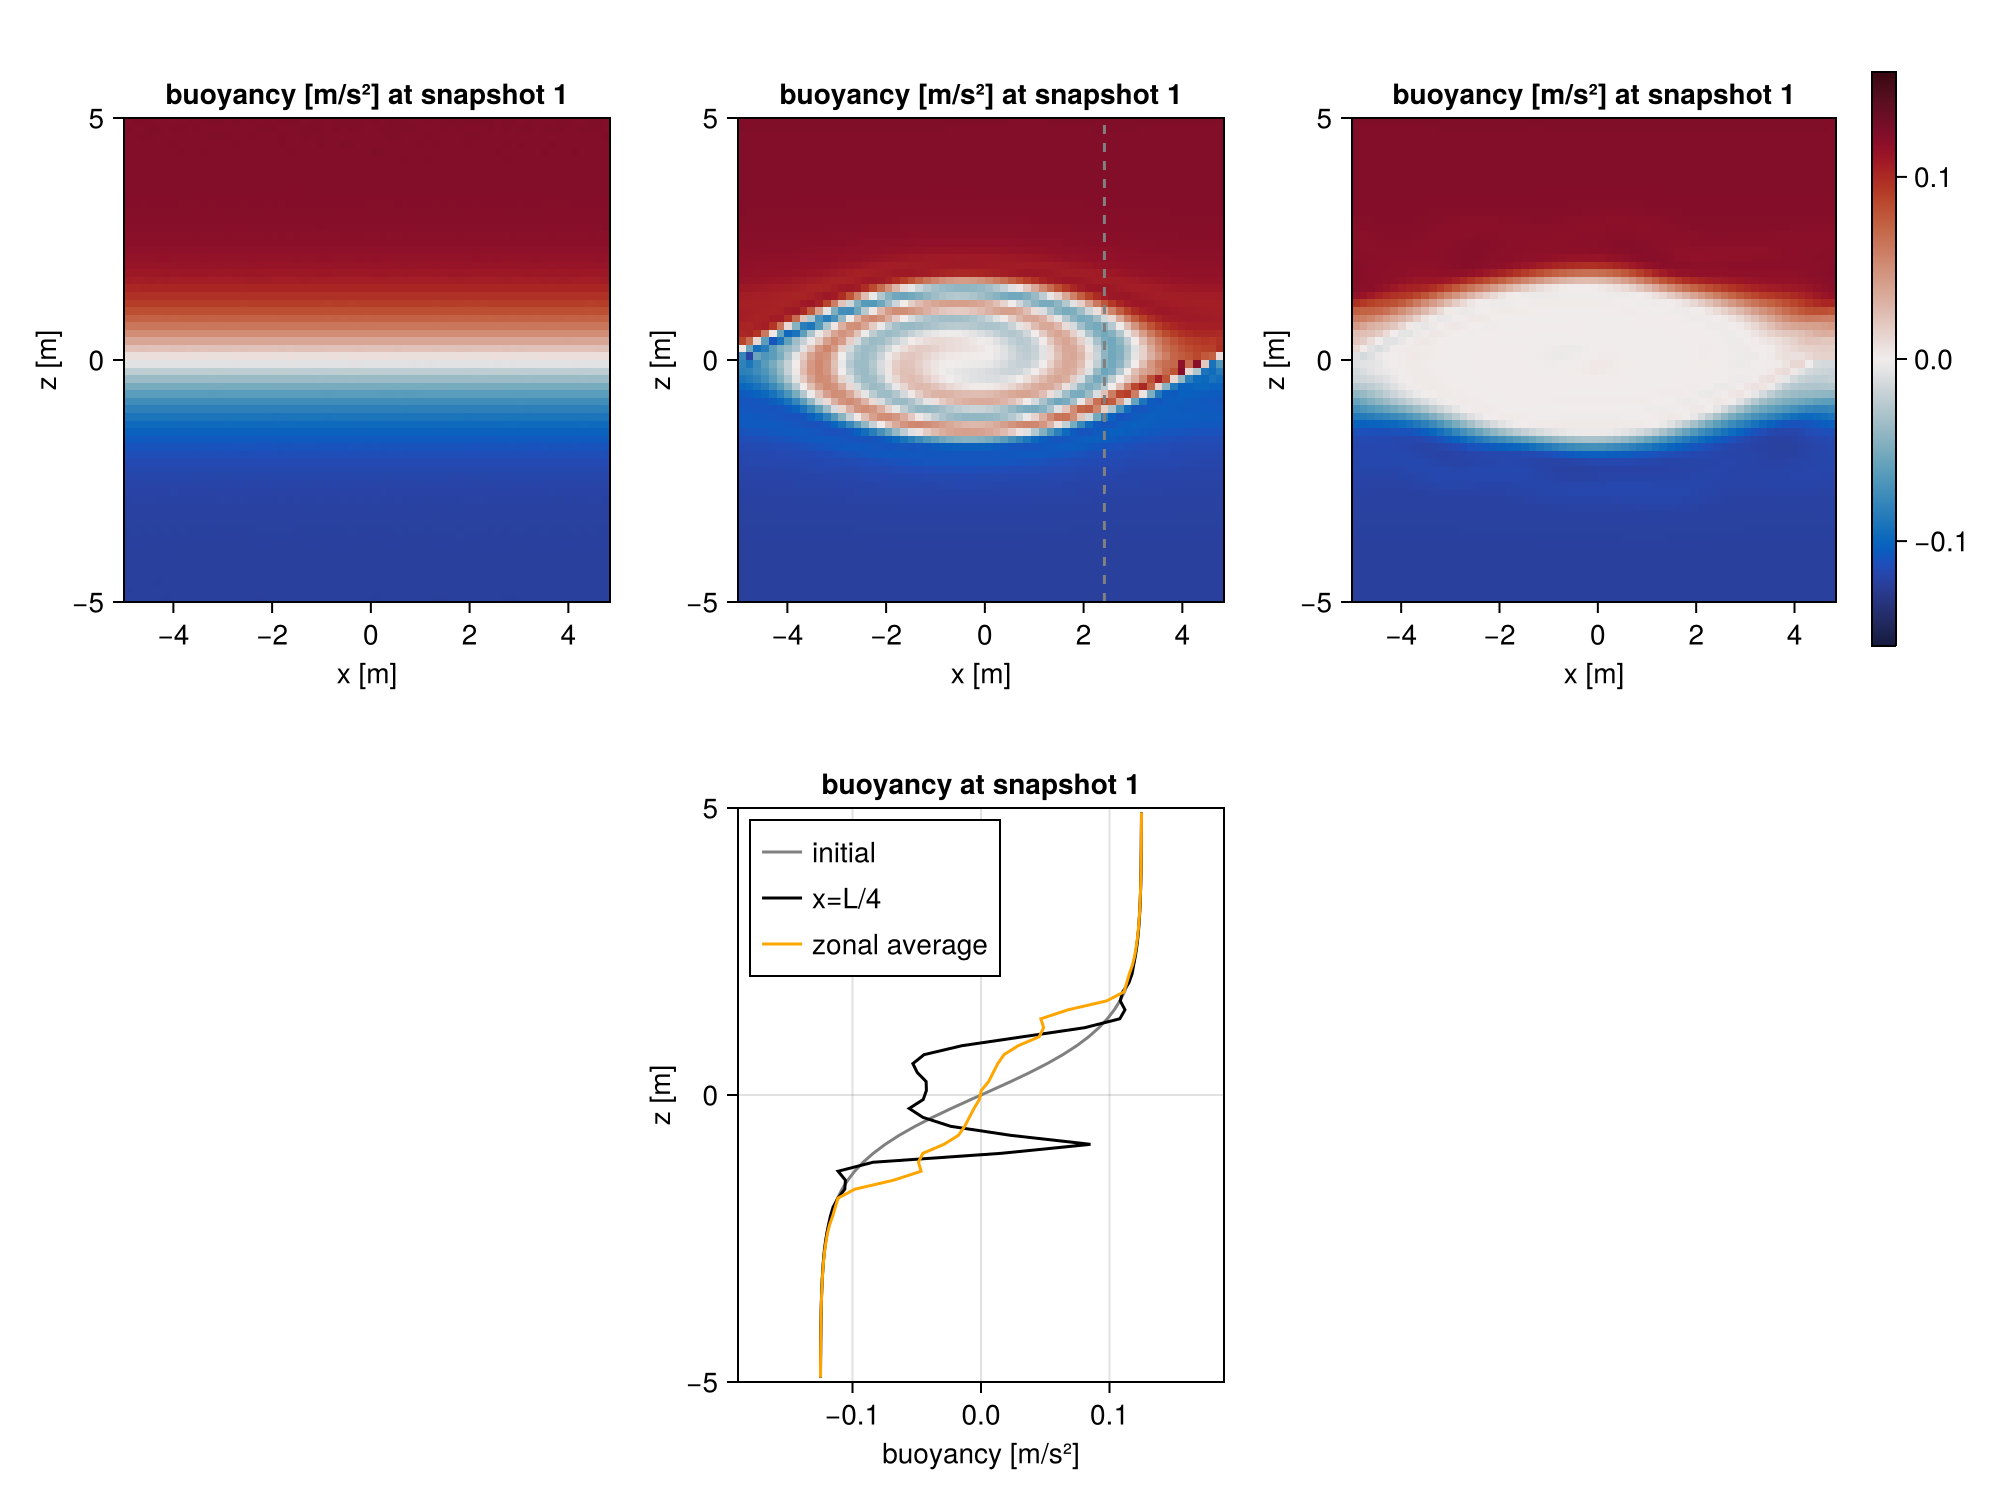

In [16]:
@info "Plotting some snapshots of the simulation at difference times..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

fig = Figure(size=(1000, 750))
t = 1
kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((ds["xF"][1], ds["xF"][end]), (ds["zF"][1], ds["zF"][end])), aspect=1,)
ax_B = Axis(fig[1, 1]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, ds["xC"], ds["zC"], ds["B"][:,1,:,t]; colorrange = B_lims, colormap = :balance)

n = 40
ax_B = Axis(fig[1, 2]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, ds["xC"], ds["zC"], ds["B"][:,1,:,n]; colorrange = B_lims, colormap = :balance)
i = grid.Nx÷2 + grid.Nx÷4
vlines!(ax_B, ds["xC"][i], linestyle=:dash, color=:gray)

n_end = length(ds["B"]["time"])
ax_B = Axis(fig[1, 3]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, ds["xC"], ds["zC"], ds["B"][:,1,:,n_end]; colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[2, 2]; title = string("buoyancy at snapshot ",t), xlabel="buoyancy [m/s²]", ylabel="z [m]", limits=(1.2.*B_lims, (ds["zF"][1], ds["zF"][end])))
l_B = lines!(ax_B, mean(ds["B"][:,1,:,1], dims=(1))[1,:], ds["zC"], color=:gray, label="initial")
l_B = lines!(ax_B, ds["B"][i,1,:,n], ds["zC"], label="x=L/4", color=:black)

Colorbar(fig[1, 4], hm_B)
leg = axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots.png", fig)

l_B = lines!(ax_B, mean(ds["B"][:,1,:,n], dims=(1))[1,:], ds["zC"], label="zonal average", color=:orange)
delete!(leg)
axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots_mean.png", fig)

close(ds)

fig